# LaplaceInterpolation.jl -- Usage and Examples.

This notebook demonstrates the usage of LaplaceInterploation.jl for interpolating missing data in 1D, 2D, and 3D problems. The package implements an approximate Laplace interpolation [@press1992] when no parameters are given, and when parameters $m\in\mathbb{Z}$ and $\epsilon > 0$ are set, the interpolant approximates a Mat`ern kernel, of which radial basis functions and polyharmonic splines are a special case. When all the data on the boundaries are known, the package automatically enforces a Dirichlet boundary condition. When the data on the boundaries are unknown, the package provides an option of implementing either Neumann boundary conditions -- that is, the derivative of the function at the unknown boundaries is 0 [cite Strikwerda or any other FDM text], or by approximating the boundary node as the average of all the neighboring nodes. We refer to the latter as "Do Nothing" boundary conditions.

In [1]:
using LaplaceInterpolation
using Plots, Random, TestImages
using LinearAlgebra, FileIO, JLD

In [2]:
function f(x)
    return x .* sin.(x)
end

f (generic function with 1 method)

# 1D Example

## Generating synthetic data 

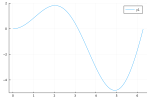

In [3]:
h = 0.01
x = 0:h:2*pi
y = f(x)
no_of_gridpoints = length(x) 
plot(x,y)

## Interpolation with Dirichlet Boundaries

We will discard about 90% of the points. We also want to ensure that we do not discard the boundaries -- that is to ensure the values at the boundaries are specified.

In [4]:
rng = MersenneTwister(1234);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
incomplete_data = copy(y)
incomplete_data[discard].=-5; #We assign -5 (or any arbitrary value) to missing data.

In [5]:
m = 1
epsilon = 0
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h);
#Dirichlet boundaries are implemented by default.

In [6]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

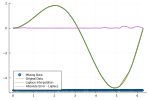

In [7]:
Plot_Matrix = [y, restored_data_laplace, error_lap]
Plots.plot(x[discard], incomplete_data[discard], seriestype = :scatter, label = "Missing Data")
Plots.plot!(x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation" "Absolute Error - Laplace" ], 
    legend=:bottomleft, lw = 3)
#png("1D_MaternInterpolation.png")



## Interpolation with Neumann Boundaries

When the boundary nodes are unknown, we enforce a zero Neumann boundary condition -- that is the derivative of the function along the outward normal at the boundaries is 0. In 1D, $\displaystyle \frac{\partial f}{\partial x} = 0$ at the end points.

In [8]:
rng = MersenneTwister(12345);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
discard = [1; discard; no_of_gridpoints]; # we are including the boundaries in the set of discarded nodes.
incomplete_data = copy(y)
incomplete_data[discard].=-5; #We assign -5 (or any arbitrary value) to missing data.

In [9]:
m = 1
epsilon = 0
bc = 1 #Setting Neumann Boundaries
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h, bc); 
#Dirichlet boundaries are implemented by default.

In [10]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

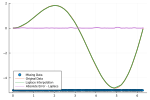

In [11]:
Plot_Matrix = [y, restored_data_laplace, error_lap]
Plots.plot(x[discard], incomplete_data[discard], seriestype = :scatter, label = "Missing Data")
Plots.plot!(x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation" "Absolute Error - Laplace" ], 
    legend=:bottomleft, lw = 3)
#png("1D_MaternInterpolation.png")

## Interpolation with "Do Nothing" Boundaries
When the boundary nodes are unknown, we approximate the unknown boundary values as the average of their neighbors.
For example in 1D, $f_0 = f_1$ and $f_N = f_{N-1}$. In 2D, $\displaystyle f_{0,0} = \frac{f_{1,0} + f_{0,1}}{2}$ and  $\displaystyle f_{1,0} = \frac{f_{0,0} + f_{2,0} +f_{1,1}}{3}$. 

In [12]:
rng = MersenneTwister(12345);
discard = randsubseq(rng, 2:no_of_gridpoints-1, 0.9) 
discard = [1; discard; no_of_gridpoints]; # we are including the boundaries in the set of discarded nodes.
incomplete_data = copy(y)
incomplete_data[discard].=-5; #We assign -5 (or any arbitrary value) to missing data.

In [13]:
m = 1
epsilon = 0
bc = 0 #Do nothing boundaries
restored_data_laplace = matern_1d_grid(incomplete_data, discard, m, epsilon, h, bc); 
#Dirichlet boundaries are implemented by default.

In [14]:
error_lap = abs.(restored_data_laplace .- y);
rel_error_lap = abs.((restored_data_laplace .- y) ./ (y .+ 1e-10));

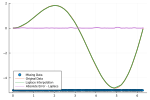

In [15]:
Plot_Matrix = [y, restored_data_laplace, error_lap]
Plots.plot(x[discard], incomplete_data[discard], seriestype = :scatter, label = "Missing Data")
Plots.plot!(x, Plot_Matrix, labels=["Original Data" "Laplace Interpolation" "Absolute Error - Laplace" ], 
    legend=:bottomleft, lw = 3)
#png("1D_MaternInterpolation.png")



# 2D Example

(512, 512)

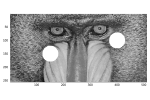

In [16]:
img = testimage("mandrill");
print(size(img))
imgg = Gray.(img);
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]
cent = [(150, 150), (100, 400)]
rad = 30*ones(Int64, 2)
discard2 = punch_holes_2D(cent, rad, rows, columns);
holeyimage1 = copy(mat)
holeyimage1[discard2] .= 1
plot(Gray.(holeyimage1))

## Interpolation with Dirichlet Boundaries

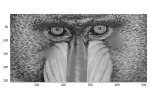

In [17]:
m = 1
epsilon = 0.0
restored_data_laplace = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h);
plot(Gray.(restored_data_laplace))

## Interpolation with Neumann Boundaries

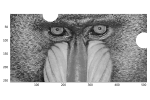

In [18]:
cent = [(0, 150), (100, 500)]
rad = 30*ones(Int64, 2)
discard2 = punch_holes_2D(cent, rad, rows, columns);
holeyimage1 = copy(mat)
holeyimage1[discard2] .= 1
plot(Gray.(holeyimage1))

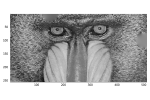

In [19]:
m = 1
epsilon = 0.0
bc = 1 #Neumann Boundaries
restored_data_laplace_n = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h, bc);
plot(Gray.(restored_data_laplace_n))

## Interpolation with "Do Nothing" Boundaries 

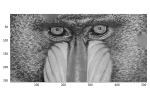

In [20]:
m = 1
epsilon = 0.0
bc = 0 #Do Nothing Boundaries
restored_data_laplace_dn = matern_2d_grid(holeyimage1, discard2, m, epsilon, h, h, bc);
plot(Gray.(restored_data_laplace_dn))

# 3D Example

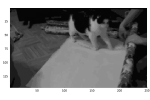

(146, 250, 126)

In [21]:
obj = load("cat_bow.gif")
GR.inline()
nsteps = 14
imgg = Gray.(obj)
for n = 1:nsteps
    IJulia.clear_output(true)
    Plots.heatmap(imgg[:,:,n])  |> display
end
print(size(imgg))

In [22]:
Nx = size(imgg,1)
Ny = size(imgg,2)
Nz = size(imgg, 3)
x = 1:Nx
y = 1:Ny
z = 1:Nz
center =[75,100, 40]
radius = 30
absolute_indices = punch_3D_cart(center, radius, x, y, z);

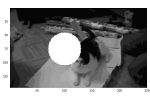

In [23]:
imgg_copy = copy(imgg)
imgg_copy[absolute_indices] .= 1
Plots.heatmap(imgg_copy[:,:,40])

## Interpolation with Dirichlet Boundaries¶

In [ ]:
m =1
epsilon = 0.0
h = 1
img_array = convert(Array{Float64}, imgg_copy)
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h)
restored_img = reshape(restored_img, Nx, Ny, Nz)

In [ ]:
Plots.heatmap(Gray.(restored_img[:,:,40]))

## Interpolation with Neumann Boundaries¶ 

In [ ]:
center =[0,200,110]
radius = 30
absolute_indices1 = punch_3D_cart(center, radius, x, y, z);
center =[100,100,110]
absolute_indices2 = punch_3D_cart(center, radius, x,y,z)
imgg_copy = copy(imgg)
absolute_indices = [absolute_indices1; absolute_indices2] #We discard data on the boundary
imgg_copy[absolute_indices] .= 1 
Plots.heatmap(imgg_copy[:,:,126]) 

In [ ]:
img_array = convert(Array{Float64}, imgg_copy)
bc = 1 #Enforcing Neumann Boundary Conditions
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
Plots.heatmap(Gray.(restored_img[:,:,126])) 

## Interpolation with "do nothing" boundary conditions

In [ ]:
bc = 0 #Enforcing "do nothing" Boundary Conditions
restored_img = matern_3d_grid(img_array, absolute_indices,m, epsilon, h, h, h, bc)
restored_img = reshape(restored_img, Nx, Ny, Nz)
Plots.heatmap(Gray.(restored_img[:,:,126])) 